# A sampe code for thunderstorm nowcasting: Identification - Tracking - Nowcasting
In this notebook, I provide an approach for implement a simple thunderstorm nowcasting from framework, where the core idea is:
1. Identification: use simple identification with contiguous area with high DBZ values.
2. Tracking: use Polar shape vectors to attach scores for each region and Hungarian Matching algorithm.
3. Nowcasting: translate storms using translate vector from tracking steps.

# 0. Preprocessing and load data into image

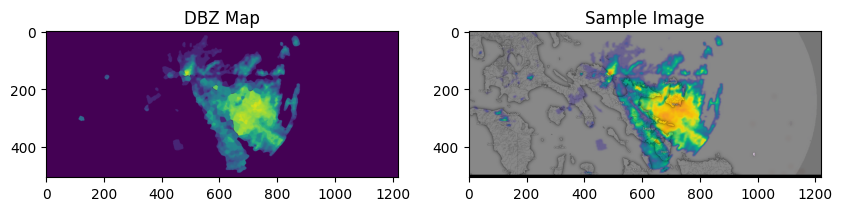

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

from src.preprocessing import read_image, windy_preprocessing_pipeline

# Load images
SOURCE_PATH = "data/images/philippines_13.269_123.832"

img_paths = [
    os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')
]

sample_img = read_image(img_paths[0])
dbz_map = windy_preprocessing_pipeline(sample_img)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(dbz_map)
plt.title('DBZ Map')

plt.subplot(1, 2, 2)
plt.imshow(sample_img)
plt.title('Sample Image')
plt.show()

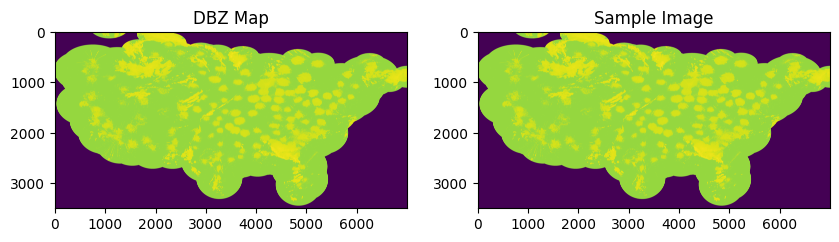

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import warnings
from tqdm import tqdm
from pathlib import Path
warnings.filterwarnings('ignore')
from src.preprocessing import read_grib, mrms_preprocessing_pipeline
SOURCE_PATH = Path(r"D:\HCMUT\HK251\WeatheringWithYou\khoan2006558\MRMS_MergedReflectivityComposite_2022061500")

grib_paths = sorted(SOURCE_PATH.glob("*.grib2"))


sample_img = read_grib(grib_paths[0])
dbz_map = mrms_preprocessing_pipeline(sample_img)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(dbz_map)
plt.title('DBZ Map')

plt.subplot(1, 2, 2)
plt.imshow(sample_img)
plt.title('Sample Image')
plt.show()


# 1. Identification storm objects from frames

Identify storm using `SimleContourIdentification` object and save into list of `StormsMap` object

--------------------


Processing images and detecting storms: 100%|██████████| 30/30 [00:16<00:00,  1.84it/s]


--------------------
Time: 2025-10-01 20:53:20 | Detected storms: 126
Time: 2025-10-01 20:53:20 | Detected storms: 132
Time: 2025-10-01 20:53:21 | Detected storms: 116
Time: 2025-10-01 20:53:21 | Detected storms: 117
Time: 2025-10-01 20:53:22 | Detected storms: 120
Time: 2025-10-01 20:53:23 | Detected storms: 118
Time: 2025-10-01 20:53:23 | Detected storms: 121
Time: 2025-10-01 20:53:24 | Detected storms: 120
Time: 2025-10-01 20:53:24 | Detected storms: 129
Time: 2025-10-01 20:53:25 | Detected storms: 131
Time: 2025-10-01 20:53:25 | Detected storms: 130
Time: 2025-10-01 20:53:26 | Detected storms: 122
Time: 2025-10-01 20:53:26 | Detected storms: 123
Time: 2025-10-01 20:53:27 | Detected storms: 133
Time: 2025-10-01 20:53:27 | Detected storms: 124
Time: 2025-10-01 20:53:28 | Detected storms: 126
Time: 2025-10-01 20:53:29 | Detected storms: 128
Time: 2025-10-01 20:53:29 | Detected storms: 129
Time: 2025-10-01 20:53:30 | Detected storms: 128
Time: 2025-10-01 20:53:30 | Detected storms: 124

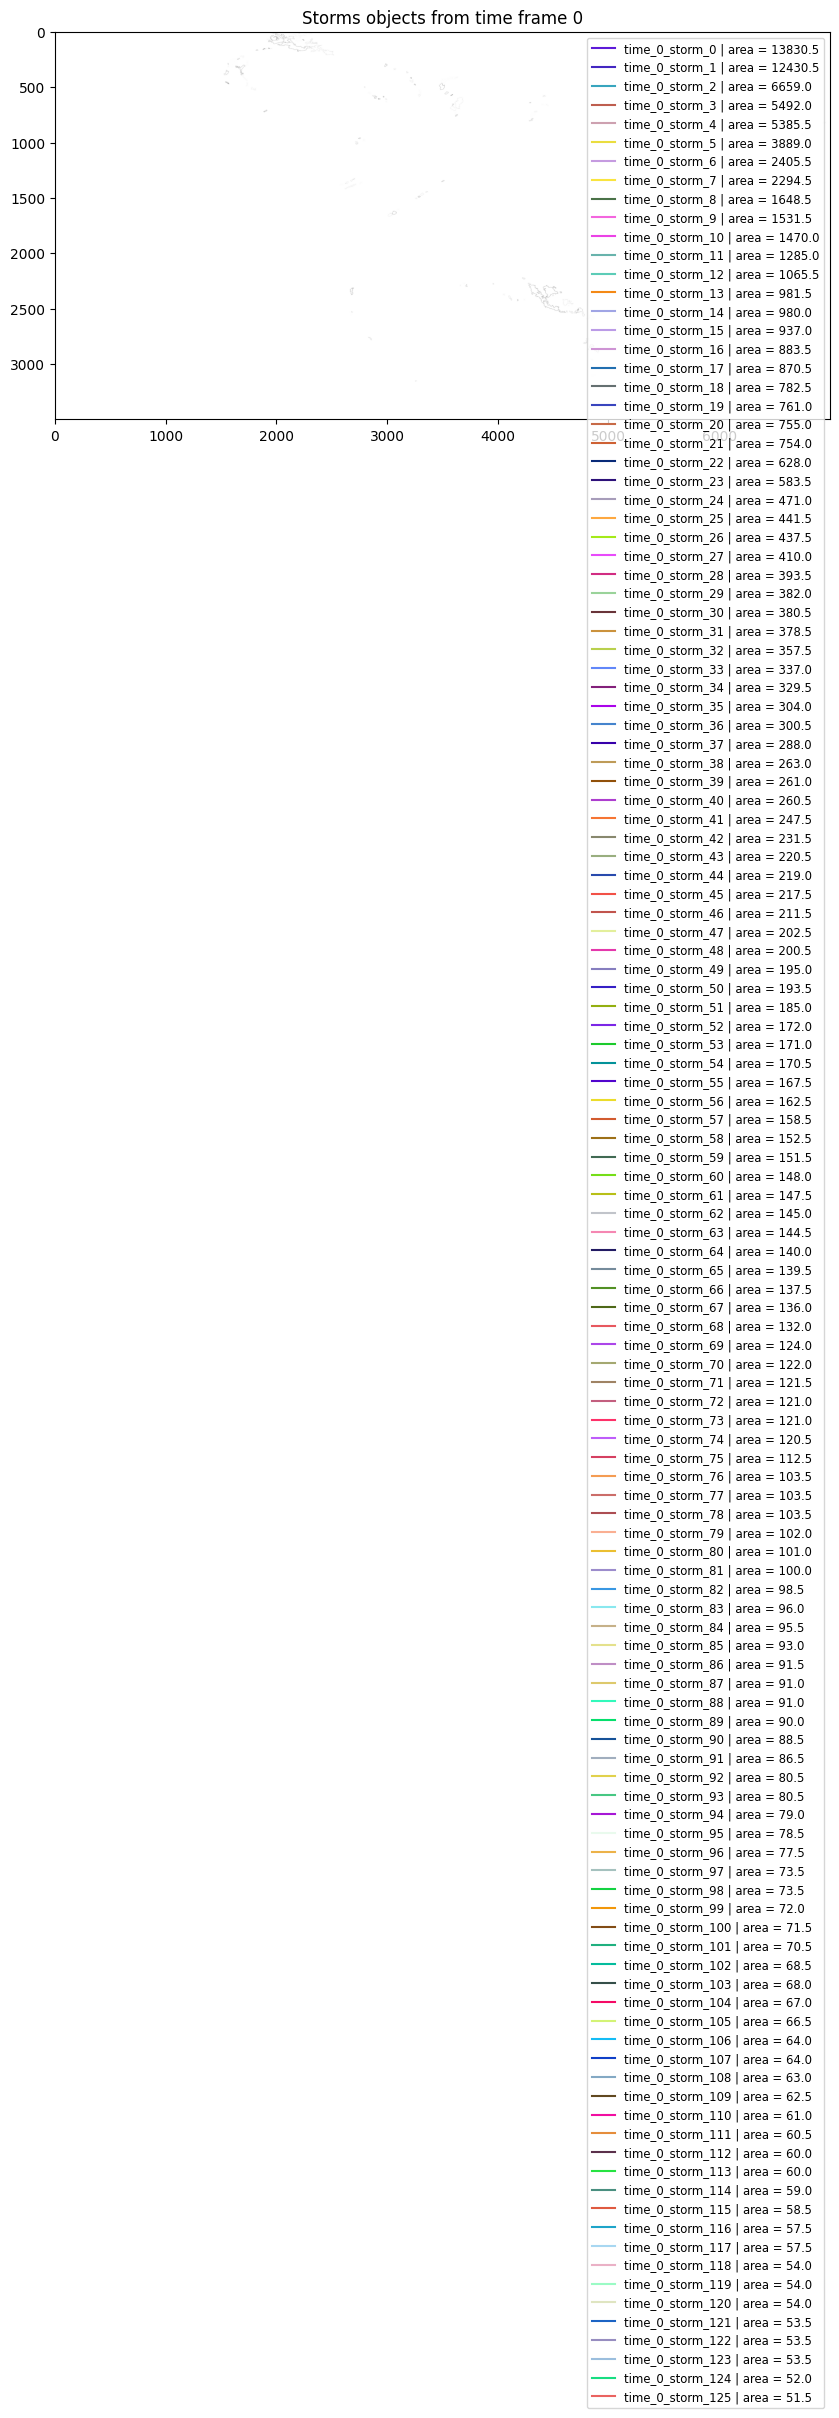

--------------------


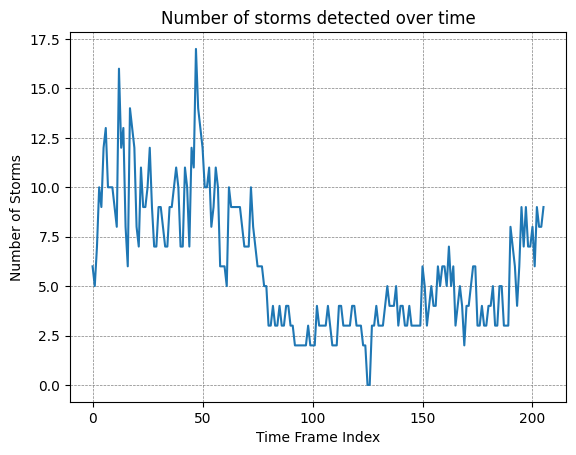

In [3]:
from src.identification import SimpleContourIdentifier, SubcellStormIdentifier
from src.preprocessing import convert_contours_to_polygons, convert_polygons_to_contours
from src.cores.contours import StormObject, StormsMap
from datetime import datetime

THRESHOLD = 35
FILTER_AREA = 20            # Discard those very small objects

identifier = SimpleContourIdentifier()
storms_map_time_lst: list[StormsMap] = []
print("-"*20)

pbar = tqdm(list(enumerate(grib_paths)), desc="Processing images and detecting storms")

plt.figure(figsize=(10, 10))
for time_idx, img_name in pbar:
    # time_frame = img_name.split('/')[-1].split('.')[0]
    # time_frame = datetime.strptime(time_frame, '%Y%m%d-%H%M%S')

    # Read image
    img = read_grib(img_name)
    dbz_map = mrms_preprocessing_pipeline(img)

    # Detect contour 
    contours = identifier.identify_storm(dbz_map, threshold=THRESHOLD, filter_area=FILTER_AREA)

    # Convert contours to polygons
    polygons = convert_contours_to_polygons(contours)
    polygons = [pol for pol in polygons if pol.area >= FILTER_AREA]
    polygons = sorted(polygons, key=lambda x: x.area, reverse=True)

    # Construct storms map
    storms = [StormObject(polygon, id=f"time_{time_idx}_storm_{idx}") for idx, polygon in enumerate(polygons)]
    storms_map = StormsMap(storms, time_frame=datetime.today())
    storms_map_time_lst.append(storms_map)

    # pbar.set_postfix(time=time_frame.strftime('%Y-%m-%d %H:%M:%S'), detected=len(contours))

print("-"*20)

plt.figure(figsize=(10, 10))
blank_image = np.ones_like(sample_img) * 255
for storm in storms_map_time_lst[0].storms:
    color = np.random.randint(0, 255, size=3).tolist()
    x_centroid, y_centroid = storm.contour.centroid.x, storm.contour.centroid.y
    
    plt.plot([], [], color=np.array(color)/255.0, label=f"{storm.id} | area = {storm.contour.area:.1f}")
    plt.scatter(x_centroid, y_centroid, color=np.array(color)/255.0, s=5)
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, color, thickness=1)

for storms_map in storms_map_time_lst:
    print(f"Time: {storms_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | Detected storms: {len(storms_map.storms)}")

print("-"*20)

plt.legend(loc="upper right", fontsize='small', ncol=1)
plt.imshow(blank_image,cmap="grey")
plt.title('Storms objects from time frame 0')
plt.legend(loc="upper right", fontsize='small', ncol=1)
plt.show()

print("-"*20)
number_of_storms = [len(storms_map.storms) for storms_map in storms_map_time_lst]
plt.plot(range(len(number_of_storms)), number_of_storms)
plt.title('Number of storms detected over time')
plt.xlabel('Time Frame Index')
plt.ylabel('Number of Storms')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

# 2. Tracking and matching storms objects from consecutive frames

### Extracting polar shape vector for all contours at all time

In [4]:
from src.cores.polar_description_vector import ShapeVector, simplify_contour, construct_shape_vector
from shapely.geometry import Polygon

RADII = [20, 40, 60, 80, 100, 120]
NUM_SECTORS = 8

class StormShapeVectors(StormObject):
    contour: Polygon
    shape_vectors: list[ShapeVector]
    coords: np.ndarray

    def __init__(self, storm_object: StormObject):
        super().__init__(contour=storm_object.contour, id=storm_object.id, time_frame=storm_object.time_frame)
        contour_arr = convert_polygons_to_contours([self.contour])[0]
        try:
            self.coords = simplify_contour(contour_arr)
        except Exception as e:
            print(f"Error when working with contour {contour_arr.shape}: {contour_arr}")
            print(f"Contour: {self.contour} | Area: {self.contour.area}")
            raise e
        self.shape_vectors = []

    def extract_shape_vectors(self, global_contours: list[Polygon], radii = [20, 40, 60], num_sectors = 8):
        vectors = [construct_shape_vector(polygons=global_contours, point=coord, radii=radii, num_sectors=num_sectors) for coord in self.coords]
        self.shape_vectors = [ShapeVector(coord=(coord[0], coord[1]), vector=vector) for coord, vector in zip(self.coords.reshape(-1, 2), vectors)]
        return self.shape_vectors

In [7]:
pbar = tqdm(storms_map_time_lst, desc="Extracting shape vectors for each storm object")
for storms_map in pbar:
    if not storms_map.storms or type(storms_map.storms[0]) is StormShapeVectors:
        continue
    global_contours = [storm.contour for storm in storms_map.storms]
    storms_map.storms = [StormShapeVectors(storm) for storm in storms_map.storms]
    [storm.extract_shape_vectors(global_contours=global_contours, radii=RADII, num_sectors=NUM_SECTORS) for storm in storms_map.storms]

assert isinstance(storms_map_time_lst[0].storms[0], StormShapeVectors), "The first storm object should be an instance of StormShapeVectors"
shapes_vectors = storms_map_time_lst[0].storms[0]

print(f"Shape vectors for each storm object at time frame 0: {len(shapes_vectors.shape_vectors)}, each vector length: {shapes_vectors.shape_vectors[0].vector.shape}")
print("-"*20)
print("Sample shape vector (first storm. object, first point):")
print(shapes_vectors.shape_vectors[0].vector)
shapes_vectors

Extracting shape vectors for each storm object: 100%|██████████| 30/30 [53:54<00:00, 107.83s/it]

Shape vectors for each storm object at time frame 0: 43, each vector length: (48,)
--------------------
Sample shape vector (first storm object, first point):
[  41.5           2.            0.            0.            0.
   29.68442662   48.10410126   99.91749544   92.60797671    0.
    0.            0.            0.           35.81557338   65.46823575
  148.04221863  307.11590181   11.35334601    0.            0.
    0.            0.          156.09235189  223.53280291  373.92850399
  123.14665399  109.18989482    0.            0.            0.
  100.08531111  278.0028876   309.10405143    0.           33.81010518
    0.            0.            0.          265.72953573  587.82983157
  328.20155461    0.            0.            0.            0.
    0.           86.77046427 1043.09631403]


StormShapeVectors(contour=<POLYGON ((1926 94, 1927 95, 1927 97, 1930 97, 1931 98, 1932 97, 1933 98, 19...>, max_dbz_centroid=30, id='time_0_storm_0', time_frame=None)

### Build a comparitive algorithm for comparing polar shape vector from two contours at consective frames

Overlapping Area:  0.4055243587797845
--------------------


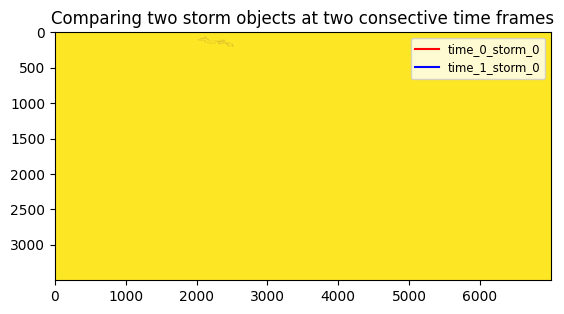

In [6]:
from src.cores.metrics import overlapping_storm_area

def overlapping_storm_area(contour_1: Polygon, contour_2: Polygon) -> float:
    intersection = contour_1.intersection(contour_2)
    union = contour_1.union(contour_2)
    return intersection.area / union.area if union.area > 0 else 0.0

storm1 = storms_map_time_lst[0].storms[0]
storm2 = storms_map_time_lst[1].storms[0]

blank_image = np.ones_like(sample_img) * 255

print("Overlapping Area: ", overlapping_storm_area(storm1.contour, storm2.contour))
print("-"*20)

color = (255,0,0)
plt.plot([], [], color=np.array(color)/255.0, label=f"{storm1.id}")
cv2.drawContours(blank_image, convert_polygons_to_contours([storm1.contour]), -1, color, thickness=1)

color = (0,0,255)
plt.plot([], [], color=np.array(color)/255.0, label=f"{storm2.id}")
cv2.drawContours(blank_image, convert_polygons_to_contours([storm2.contour]), -1, color, thickness=1)

plt.legend(loc="upper right", fontsize='small', ncol=1)
plt.imshow(blank_image)
plt.title('Comparing two storm objects at two consective time frames')
plt.show()

### Matching two shape vectors at difference points
- For each point in `ShapeVector`, filter out those `coord` attributes too far; use Euclidean distance on `vector` attribute to compare shape vector between two shape vectors.
- First, construct function to compute the valid matching of shape vector coordinates from two shape vectors. For each valid matching between two points in two contours, estimate their displacement vector.
- Then, from  Use K-means clustering for remove those outlier of displacement data.
- Define overall displacement of whole storm by center of those displacement data.

In [7]:
import time
from sklearn.cluster import KMeans
from shapely.affinity import translate

CLUSTER_COUNT = 2
CIRCLE_AREA = RADII[-1] * RADII[-1] * np.pi

def _compute_similarity_pair(vector_1: np.ndarray, vector_2: np.ndarray, circle_area: float):
    return np.linalg.norm((vector_1 - vector_2)) / circle_area

def compute_valid_pairs(
        prev_storm: StormShapeVectors,
        curr_storm: StormShapeVectors,
        circle_area: float,
        maximum_displacement: float = 10,
        thresholds: list[float] = [0.05, 0.08, 0.1]
    ) -> list[tuple[float, float]]:
    """
        Compute movement between two lists of shape vectors. For all pairs of points between two storms, if the similarity score is below a certain threshold and the distance between two points is below a certain maximum displacement, we consider this pair as a valid movement. If the number of valid movements exceeds 20% of the number of vertices, we return this list of movements.

        Args:
            prev_storm (Storm): Previous storm instance.
            curr_storm (Storm): Current storm instance.
            circle_area (float): Area of the circle used in shape vector computation.
            maximum_displacement (float): Maximum allowed displacement between two points.
            thresholds (list[float]): List of ascending thresholds for similarity scores.

        Returns:
            List[Tuple[float, float]]: List of valid displacements.
    """
    if prev_storm.contour.distance(curr_storm.contour) > maximum_displacement:
        return []

    num_vertices = max(len(prev_storm.shape_vectors), len(curr_storm.shape_vectors))
    displacements = [[]] * len(thresholds)

    for svector_1 in prev_storm.shape_vectors:
        for svector_2 in curr_storm.shape_vectors:
            if np.linalg.norm(np.array(svector_1.coord) - np.array(svector_2.coord)) > maximum_displacement:
                continue
            score = _compute_similarity_pair(svector_1.vector, svector_2.vector, circle_area)

            for idx, threshold in enumerate(thresholds):
                if score < threshold:
                    v1, v2 = svector_1.coord, svector_2.coord
                    displacements[idx].append((v2[0]-v1[0], v2[1]-v1[1]))
    
    # Only return the the matching pairs at the first threshold that has enough valid pairs
    for idx in range(len(thresholds)):
        if len(displacements[idx]) > (num_vertices / 5):
            return displacements[idx]
    
    return []

def get_translate_vector(displacement_list: list[tuple[float, float]], cluster_counts: int=CLUSTER_COUNT) -> tuple[float, float, np.ndarray]:
    """
    From list of displacements, use K-means clustering to find the largest cluster and return its center as the overall translation vector.
    Return the translation vector (x_offset, y_offset) and the labels of each displacement point for visualization.
    """
    if len(displacement_list) == 0:
        return 0.0, 0.0, np.array([])
    kmeans = KMeans(n_clusters=CLUSTER_COUNT)
    kmeans.fit(displacement_list)
    centers = kmeans.cluster_centers_
    cluster_counts = np.bincount(kmeans.labels_)
    max_cluster_idx = np.argmax(cluster_counts)

    translate_vector = centers[max_cluster_idx]
    return translate_vector[0], translate_vector[1], kmeans.labels_

Translate vector (K-means center of the largest cluster):  (np.float64(1.2727272727272736), np.float64(-0.727272727272727))
--------------------
Predicted displacement: (np.float64(1.2727272727272736), np.float64(-0.727272727272727))
Overlapping ratio before moving: 0.4055243587797845
Overlapping ratio after moving: 0.38857835901232557
--------------------


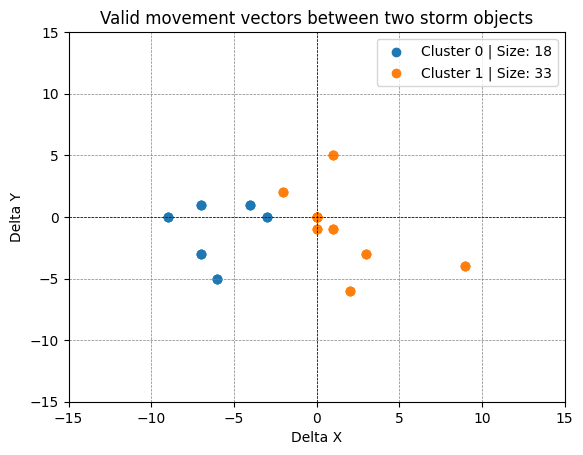

In [8]:
from src.cores.metrics import overlapping_storm_area

storm1 = storms_map_time_lst[0].storms[0]
storm2 = storms_map_time_lst[1].storms[0]
displacement_list = compute_valid_pairs(storm1, storm2, CIRCLE_AREA)
xoff, yoff, labels = get_translate_vector(displacement_list, cluster_counts=CLUSTER_COUNT)

print("Translate vector (K-means center of the largest cluster): ", (xoff, yoff))
print("-"*20)

# displacement_vector = np.array([centers[max_cluster_idx][0], centers[max_cluster_idx][1]]).reshape(1, 1, 2)
predicted_polygon = translate(storm1.contour, xoff=xoff, yoff=yoff)
overlapping = overlapping_storm_area(predicted_polygon, storm2.contour)
print(f"Predicted displacement: {(xoff, yoff)}")
print(f"Overlapping ratio before moving: {overlapping_storm_area(storm1.contour, storm2.contour)}")
print(f"Overlapping ratio after moving: {overlapping}")
print("-"*20)

for cluster_id in range(CLUSTER_COUNT):
    cluster_points = [p for p, lbl in zip(displacement_list, labels) if lbl == cluster_id]
    xs, ys = zip(*cluster_points)
    plt.scatter(xs, ys, label=f"Cluster {cluster_id} | Size: {len(cluster_points)}")

plt.title('Valid movement vectors between two storm objects')
plt.xlabel('Delta X')
plt.ylabel('Delta Y')
plt.xlim(-15, 15)
plt.ylim(-15, 15)

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()

plt.show()

### Establishing disparity matrix from two consecutive frame and use Hungarian Matching Optimization for detecting matching storms

In [9]:
from src.tracking import BaseTracker

class PolarVectorTracker(BaseTracker):
    def _cost_function(self, prev_contour: StormShapeVectors, curr_contour: StormShapeVectors) -> float:
        displacement_list = compute_valid_pairs(prev_contour, curr_contour, CIRCLE_AREA)
        if len(displacement_list) == 0:
            return 0.0
        xoff, yoff, _ = get_translate_vector(displacement_list, cluster_counts=CLUSTER_COUNT)
        predicted_polygon = translate(prev_contour.contour, xoff=xoff, yoff=yoff)
        overlapping = overlapping_storm_area(predicted_polygon, curr_contour.contour)
        return overlapping

tracker_controller = PolarVectorTracker()
disparity_matrix, assignments = tracker_controller.construct_disparity_matrix(
    storms_map1=storms_map_time_lst[0],
    storms_map2=storms_map_time_lst[1],
    include_matches=True,
    cancel_threshold=0.1
)

for i, j in assignments:
    print(f"Storm {storms_map_time_lst[0].storms[i].id} matched with Storm {storms_map_time_lst[1].storms[j].id} | Similarity score: {disparity_matrix[i, j]:.4f}")

Storm time_0_storm_0 matched with Storm time_1_storm_6 | Similarity score: 0.1261
Storm time_0_storm_1 matched with Storm time_1_storm_1 | Similarity score: 0.8730
Storm time_0_storm_2 matched with Storm time_1_storm_2 | Similarity score: 0.8884
Storm time_0_storm_3 matched with Storm time_1_storm_0 | Similarity score: 0.2978
Storm time_0_storm_4 matched with Storm time_1_storm_3 | Similarity score: 0.7917
Storm time_0_storm_5 matched with Storm time_1_storm_4 | Similarity score: 0.6076
Storm time_0_storm_6 matched with Storm time_1_storm_5 | Similarity score: 0.7793
Storm time_0_storm_7 matched with Storm time_1_storm_8 | Similarity score: 0.5208
Storm time_0_storm_8 matched with Storm time_1_storm_10 | Similarity score: 0.7437
Storm time_0_storm_9 matched with Storm time_1_storm_13 | Similarity score: 0.4454
Storm time_0_storm_10 matched with Storm time_1_storm_9 | Similarity score: 0.6750
Storm time_0_storm_11 matched with Storm time_1_storm_12 | Similarity score: 0.7372
Storm time_

## Matching for consecutive frames

In [10]:
# Dictionary for tracking storm history
storms_history_dict: dict[str, list[StormShapeVectors]] = {
    storm.id: [storm] for storm in storms_map_time_lst[0].storms
}

for idx in tqdm(range(len(storms_map_time_lst)-1)):
    prev_storms_map, curr_storms_map = storms_map_time_lst[idx], storms_map_time_lst[idx+1]
    disparity_matrix, assignments = tracker_controller.construct_disparity_matrix(prev_storms_map, curr_storms_map, include_matches=True, cancel_threshold=0.1)

    if not assignments:
        continue
    
    # Rename the storm IDs based on assignments
    for i, j in assignments:
        curr_storms_map.storms[j].id = prev_storms_map.storms[i].id

    # Update the storm history dictionary
    for storm in curr_storms_map.storms:
        if not storm.id in storms_history_dict:
            storms_history_dict[storm.id] = []
        storms_history_dict[storm.id].append(storm)

100%|██████████| 29/29 [01:18<00:00,  2.71s/it]


# 3. Generate nowcasting image and evaluate result
Methods: using local constant vector motion with exponential decay to update new motion. Whenever matching new storm, the movement is determined as:
$$
    v_{x, t+1} := \alpha \cdot v_{x, t} + (1-\alpha) \cdot \delta_{x, t+1}
$$


Naive nowcasting prediction: Only using the last map without any motion update
Results:
	Time 2025-01-08 03:16:44 | POD: 0.9424 | FAR: 0.0831 | CSI: 0.8683
	Time 2025-01-08 03:22:45 | POD: 0.8285 | FAR: 0.5211 | CSI: 0.4357
	Time 2025-01-08 03:28:45 | POD: 0.8993 | FAR: 0.1524 | CSI: 0.7741
	Time 2025-01-08 03:34:45 | POD: 0.8945 | FAR: 0.1638 | CSI: 0.7612
	Time 2025-01-08 03:40:45 | POD: 0.6881 | FAR: 0.4947 | CSI: 0.4111
	Time 2025-01-08 03:46:46 | POD: 0.8752 | FAR: 0.1412 | CSI: 0.7651
	Time 2025-01-08 03:52:46 | POD: 0.4498 | FAR: 0.5680 | CSI: 0.2826
	Time 2025-01-08 03:58:46 | POD: 0.8317 | FAR: 0.2298 | CSI: 0.6663
	Time 2025-01-08 04:04:46 | POD: 0.8060 | FAR: 0.1808 | CSI: 0.6842
	Time 2025-01-08 04:10:47 | POD: 0.7158 | FAR: 0.3455 | CSI: 0.5195
	Time 2025-01-08 04:16:47 | POD: 0.8580 | FAR: 0.1429 | CSI: 0.7506
	Time 2025-01-08 04:22:47 | POD: 0.4297 | FAR: 0.6329 | CSI: 0.2468
	Time 2025-01-08 04:28:47 | POD: 0.7437 | FAR: 0.3793 | CSI: 0.5113
	Time 2025-01-08 04:34:48 | 

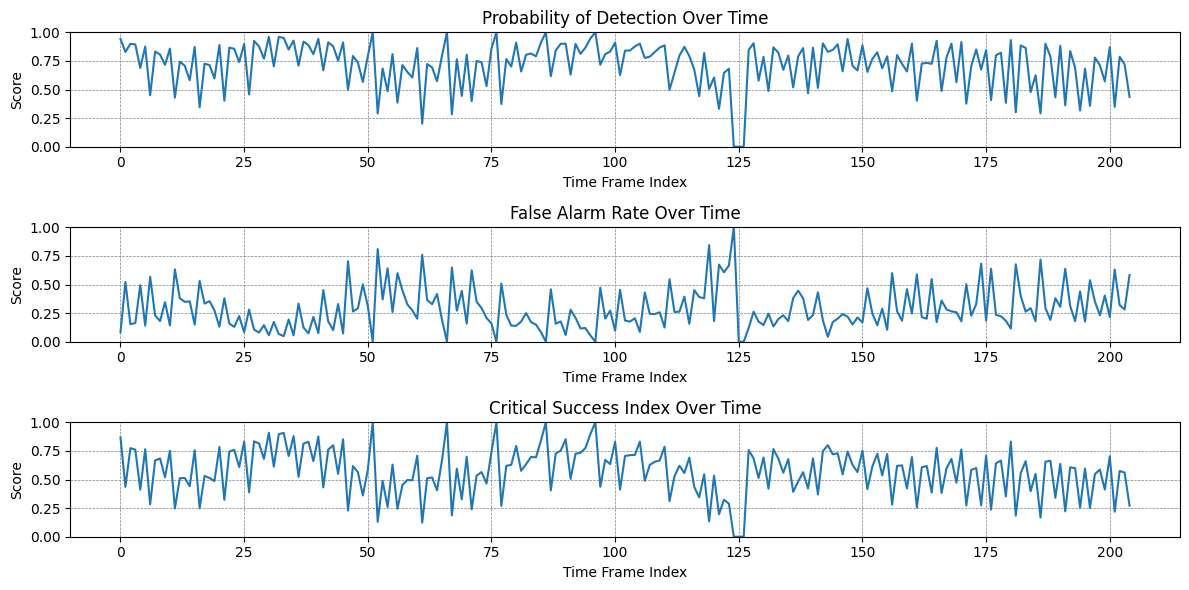

In [16]:
from src.cores.metrics import pod_score, far_score, csi_score

bm_pod_scores = []
bm_far_scores = []
bm_csi_scores = []

print("Naive nowcasting prediction: Only using the last map without any motion update")
print("Results:")
for prev_storm, curr_storm in zip(storms_map_time_lst[:-1], storms_map_time_lst[1:]):
    bm_pod_scores.append(pod_score(prev_storm, curr_storm))
    bm_far_scores.append(far_score(prev_storm, curr_storm))
    bm_csi_scores.append(csi_score(prev_storm, curr_storm))
    print(f"\tTime {curr_storm.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | POD: {pod_score(prev_storm, curr_storm):.4f} | FAR: {far_score(prev_storm, curr_storm):.4f} | CSI: {csi_score(prev_storm, curr_storm):.4f}")

indexes = range(len(bm_pod_scores))
scores = [bm_pod_scores, bm_far_scores, bm_csi_scores]
titles = ['Probability of Detection Over Time', 'False Alarm Rate Over Time', 'Critical Success Index Over Time']

plt.figure(figsize=(12, 6))

for i, title in enumerate(titles):
    plt.subplot(3, 1, i+1)
    plt.plot(indexes, scores[i], label=title)
    plt.title(title)
    plt.xlabel('Time Frame Index')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.tight_layout()
plt.show()

## Now casting using constant vector with exponential decay motion

In [17]:
from src.nowcasting import BaseStormMotion, ConstantVectorMotion

class ConstantVectorMotion(BaseStormMotion):
    """
        Simplest motion estimation: assume motion following single vector between consecutive images and no change on shape.
        Use exponential decay to reduce the effect of previous vectors.
    """
    movement_vectors: list[tuple[float, float]]
    centroids_track: list[tuple[float, float]]
    x_vector: float
    y_vector: float
    exponential_decay: float

    def __init__(self, born_idx: int, original_centroid: tuple[float, float], exponential_decay: float = 0.7) -> None:
        self.movement_vectors = []
        self.x_vector = 0.0
        self.y_vector = 0.0

        self.born_idx = born_idx
        self.centroids_track = [original_centroid]
        self.exponential_decay = exponential_decay
        
        # Only use for plotting contours
        self.color = np.random.randint(0, 255, size=3).tolist()

    def estimate_motion(self, storm_object: StormObject) -> StormObject:
        new_object = storm_object.copy()
        new_object.contour = translate(new_object.contour, xoff=self.x_vector, yoff=self.y_vector)

        return new_object

    def __add__(self, other: 'ConstantVectorMotion') -> 'ConstantVectorMotion':
        combined = ConstantVectorMotion()
        combined.x_vector = self.x_vector + other.x_vector
        combined.y_vector = self.y_vector + other.y_vector
        return combined

    def update_motion(self, new_translate: tuple[float, float], new_centroid: tuple[float, float]) -> None:
        self.movement_vectors.append(new_translate)
        self.x_vector = self.exponential_decay * self.x_vector + (1 - self.exponential_decay) * new_translate[0]
        self.y_vector = self.exponential_decay * self.y_vector + (1 - self.exponential_decay) * new_translate[1]

        self.centroids_track.append(new_centroid)

        return None

Total unique storms tracked: 528 / 3735 storm instances
Storm ID: time_0_storm_0 | Lifespan: 29
Storm ID: time_0_storm_1 | Lifespan: 27
Storm ID: time_0_storm_2 | Lifespan: 12
Storm ID: time_0_storm_3 | Lifespan: 1
Storm ID: time_0_storm_4 | Lifespan: 30
Storm ID: time_0_storm_5 | Lifespan: 30
Storm ID: time_0_storm_6 | Lifespan: 30
Storm ID: time_0_storm_7 | Lifespan: 30
Storm ID: time_0_storm_8 | Lifespan: 30
Storm ID: time_0_storm_9 | Lifespan: 2
Storm ID: time_0_storm_10 | Lifespan: 30
Storm ID: time_0_storm_11 | Lifespan: 30
Storm ID: time_0_storm_12 | Lifespan: 30
Storm ID: time_0_storm_13 | Lifespan: 16
Storm ID: time_0_storm_14 | Lifespan: 2
Storm ID: time_0_storm_15 | Lifespan: 10
Storm ID: time_0_storm_16 | Lifespan: 30
Storm ID: time_0_storm_17 | Lifespan: 30
Storm ID: time_0_storm_18 | Lifespan: 14
Storm ID: time_0_storm_19 | Lifespan: 1
Storm ID: time_0_storm_20 | Lifespan: 30
Storm ID: time_0_storm_21 | Lifespan: 30
Storm ID: time_0_storm_22 | Lifespan: 30
Storm ID: time_

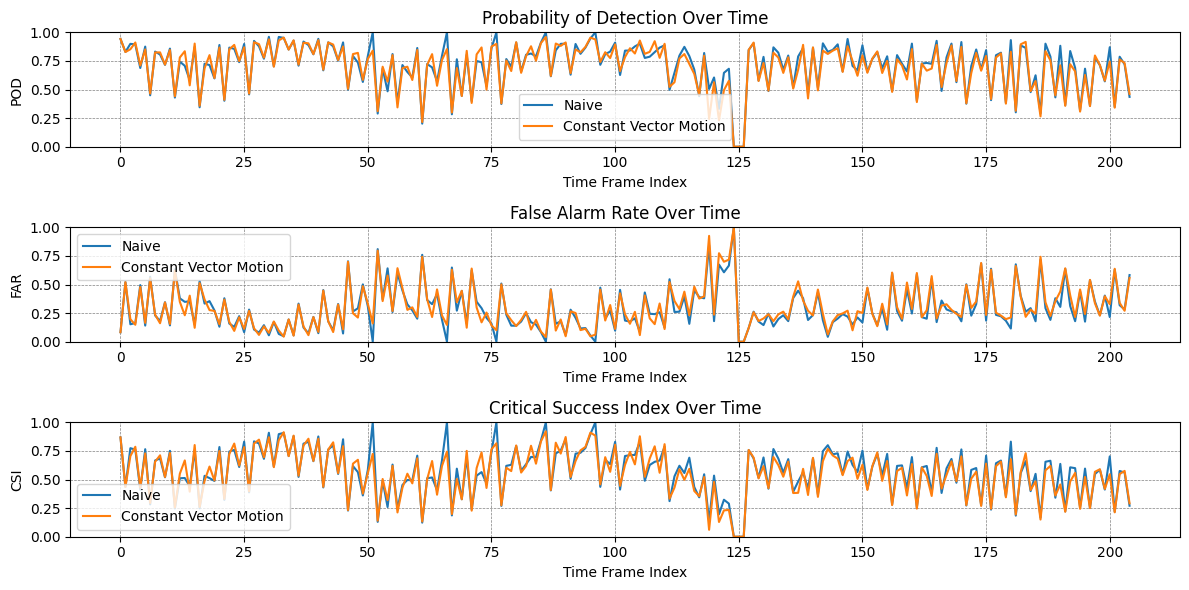

In [11]:
constant_vector_pod_scores = []
constant_vector_far_scores = []
constant_vector_csi_scores = []

EXPONENTIAL_DECAY = 0.5
print("Nowcasting prediction using local constant vector motion with exponential decay:")

motion_vectors: dict[str, ConstantVectorMotion] = {
    storm.id: ConstantVectorMotion(born_idx=0, original_centroid=(storm.contour.centroid.x, storm.contour.centroid.y), exponential_decay=EXPONENTIAL_DECAY) for storm in storms_map_time_lst[0].storms
}

# Save temporary previous storms for reference
temp_prev_storms = {storm.id: storm for storm in storms_map_time_lst[0].storms}

for idx, storms_map in enumerate(storms_map_time_lst[1:]):
    # Perform motion update for all storms in the current frame
    predicted_storms_map = StormsMap([], time_frame=storms_map.time_frame)
    for storm_obj in temp_prev_storms.values():
        new_storm = motion_vectors[storm_obj.id].estimate_motion(storm_obj)
        predicted_storms_map.storms.append(new_storm)
        
    constant_vector_csi_scores.append(csi_score(predicted_storms_map, storms_map))
    constant_vector_far_scores.append(far_score(predicted_storms_map, storms_map))
    constant_vector_pod_scores.append(pod_score(predicted_storms_map, storms_map))
    print(f"\tIndex {idx} | Time {storms_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | POD: {pod_score(predicted_storms_map, storms_map):.4f} | FAR: {far_score(predicted_storms_map, storms_map):.4f} | CSI: {csi_score(predicted_storms_map, storms_map):.4f}")

    # Update motion vectors based on matching results
    for storm_obj in storms_map.storms:
        centroids = (storm_obj.contour.centroid.x, storm_obj.contour.centroid.y)
        if storm_obj.id not in motion_vectors:
            motion_vectors[storm_obj.id] = ConstantVectorMotion(original_centroid=centroids, born_idx=idx+1, exponential_decay=EXPONENTIAL_DECAY)
        else:
            displacement_list = compute_valid_pairs(prev_storm=temp_prev_storms[storm_obj.id], curr_storm=storm_obj, circle_area=CIRCLE_AREA)
            xoff, yoff, _ = get_translate_vector(displacement_list, cluster_counts=CLUSTER_COUNT)
            motion_vectors[storm_obj.id].update_motion((xoff, yoff), new_centroid=centroids)

    # Update temporary previous storms
    temp_prev_storms = {storm.id: storm for storm in storms_map.storms}

indexes = range(len(bm_pod_scores))
scores = [
    (bm_pod_scores, constant_vector_pod_scores), 
    (bm_far_scores, constant_vector_far_scores),
    (bm_csi_scores, constant_vector_csi_scores)
]
titles = ['Probability of Detection Over Time', 'False Alarm Rate Over Time', 'Critical Success Index Over Time']
ylabels = ['POD', 'FAR', 'CSI']

plt.figure(figsize=(12, 6))

for i, title in enumerate(titles):
    plt.subplot(3, 1, i+1)
    plt.plot(indexes, scores[i][0], label='Naive')
    plt.plot(indexes, scores[i][1], label='Constant Vector Motion')
    plt.title(title)
    plt.xlabel('Time Frame Index')
    plt.ylabel(ylabels[i])
    plt.ylim(0, 1)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.legend()

plt.tight_layout()
plt.show()

In [21]:
TESTING_IDX = 12

def draw_motion_in_frame(map_idx: int):
    storms_map = storms_map_time_lst[map_idx]

    plt.figure(figsize=(8, 8))
    blank_image = np.ones_like(sample_img) * 255

    # Draw the contours and current centroids
    for storm in storms_map.storms:
        color = motion_vectors[storm.id].color
        color_bgr = (int(color[2]), int(color[1]), int(color[0]))

        contour = convert_polygons_to_contours([storm.contour])[0]
        centroid_x, centroid_y = storm.contour.centroid.x, storm.contour.centroid.y
        start_centroid_x, start_centroid_y = motion_vectors[storm.id].centroids_track[0]
        
        cv2.drawContours(blank_image, [contour], -1, color, thickness=1)

        cv2.circle(blank_image, (int(centroid_x), int(centroid_y)), radius=3, color=color_bgr, thickness=-1)
        cv2.drawMarker(blank_image, (int(start_centroid_x), int(start_centroid_y)), color=color_bgr, markerType=cv2.MARKER_TILTED_CROSS, markerSize=6, thickness=2)

        motion_vector = motion_vectors[storm.id]

        pts_int = [(int(round(x)), int(round(y))) for x, y in motion_vector.centroids_track[:map_idx-motion_vector.born_idx+1]]

        for p1, p2 in zip(pts_int[:-1], pts_int[1:]):
            cv2.line(blank_image, p1, p2, (0, 0, 0), 1, cv2.LINE_AA)

    return blank_image

In [ ]:
idx = 0
WINDOW_NAME = "Storms Viewer"

# Button positions (x1, y1, x2, y2)
buttons = {
    "prev": (50, 350, 150, 390),
    "next": (450, 350, 550, 390),
    "quit": (250, 350, 350, 390)
}

# Helper: draw buttons
def draw_buttons(img):
    btn_color = (80, 80, 80)
    text_color = (255, 255, 255)
    for name, (x1, y1, x2, y2) in buttons.items():
        cv2.rectangle(img, (x1, y1), (x2, y2), btn_color, -1)
        cv2.putText(img, name.capitalize(), (x1 + 15, y2 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 2)
    return img

# Mouse callback to handle clicks
clicked_button = None
def mouse_callback(event, x, y, flags, param):
    global clicked_button
    if event == cv2.EVENT_LBUTTONDOWN:
        for name, (x1, y1, x2, y2) in buttons.items():
            if x1 <= x <= x2 and y1 <= y <= y2:
                clicked_button = name

cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_NORMAL)
cv2.setMouseCallback(WINDOW_NAME, mouse_callback)

while True:
    # Draw main image and buttons
    img_to_show = draw_motion_in_frame(idx)
    img_to_show = draw_buttons(img_to_show)
    cv2.imshow(WINDOW_NAME, img_to_show)

    # Wait small delay to allow window interaction
    key = cv2.waitKey(100)

    if clicked_button == "next":
        if idx < len(storms_map_time_lst) - 1:
            idx += 1
        else:
            cv2.displayOverlay(WINDOW_NAME, "Already at last frame", 1000)
    elif clicked_button == "prev":
        if idx > 0:
            idx -= 1
        else:
            cv2.displayOverlay(WINDOW_NAME, "Already at first frame", 1000)
    elif clicked_button == "quit":
        break

    clicked_button = None  # reset click state

cv2.destroyAllWindows()


## Visualization
Use storm history to establish the motion vector of storms, updated frame by frame

In [20]:
storms_movement_history_dict: dict[str, list[tuple[float, float]]] = {
    storm_id: [] for storm_id in storms_history_dict.keys()
}

for storm_id, storms in storms_history_dict.items():
    if len(storms) < 3:  # Only print storms that lasted at least 3 time frames
        continue
    print(f"Storm ID: {storm_id} | Lifespan: {len(storms)} | Starting: {storms[0].time_frame.strftime('%Y-%m-%d %H:%M:%S')} | Ending: {storms[-1].time_frame.strftime('%Y-%m-%d %H:%M:%S')}")
    for prev_storm, curr_storm in zip(storms[:-1], storms[1:]):
        displacement_list = compute_valid_pairs(prev_storm, curr_storm, CIRCLE_AREA)
        xoff, yoff, _ = get_translate_vector(displacement_list, cluster_counts=CLUSTER_COUNT)
        storms_movement_history_dict[storm_id].append((xoff, yoff))
    print("-"*15)

Storm ID: time_0_storm_0 | Lifespan: 15 | Starting: 2025-01-08 03:10:44 | Ending: 2025-01-08 04:34:48
---------------
Storm ID: time_0_storm_1 | Lifespan: 75 | Starting: 2025-01-08 03:10:44 | Ending: 2025-01-08 10:35:02
---------------
Storm ID: time_2_storm_1 | Lifespan: 10 | Starting: 2025-01-08 03:22:45 | Ending: 2025-01-08 04:16:47
---------------
Storm ID: time_2_storm_3 | Lifespan: 5 | Starting: 2025-01-08 03:22:45 | Ending: 2025-01-08 03:46:46
---------------
Storm ID: time_2_storm_4 | Lifespan: 5 | Starting: 2025-01-08 03:22:45 | Ending: 2025-01-08 03:46:46
---------------
Storm ID: time_2_storm_5 | Lifespan: 5 | Starting: 2025-01-08 03:22:45 | Ending: 2025-01-08 03:46:46
---------------
Storm ID: time_3_storm_8 | Lifespan: 4 | Starting: 2025-01-08 03:28:45 | Ending: 2025-01-08 03:46:46
---------------
Storm ID: time_7_storm_1 | Lifespan: 25 | Starting: 2025-01-08 03:52:46 | Ending: 2025-01-08 06:16:52
---------------
Storm ID: time_7_storm_2 | Lifespan: 3 | Starting: 2025-01-0

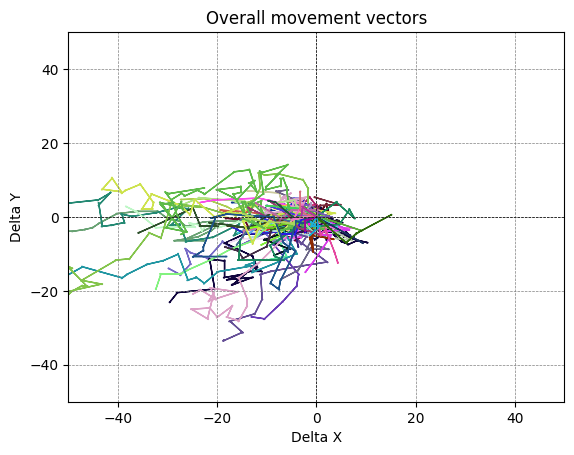

: 

In [ ]:
storm_id, test_vector = next(iter(storms_movement_history_dict.items()))
start_point = (0, 0)

for storm_id, test_vector in storms_movement_history_dict.items():
    color = np.random.randint(0, 255, size=3) / 255
    start_point = (0, 0)
    for vec in test_vector:
        end_points = (start_point[0] + vec[0], start_point[1] + vec[1])
        plt.arrow(start_point[0], start_point[1], vec[0], vec[1], head_width=0.2, head_length=0.3, fc=color, ec=color)
        start_point = end_points
    plt.scatter([], [], color=color, label=f'{storm_id}')

plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.title(f"Overall movement vectors")
plt.xlabel('Delta X')
plt.ylabel('Delta Y')
plt.show()